In [4]:
# from I3Tray import *
# import icecube

import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
import pylab
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import pickle
import xml.etree.ElementTree as ET

import yaml

%matplotlib inline

In [5]:
plt.rcParams.update({'font.size': 24})

In [6]:
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# mpl.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

In [7]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# constants

In [8]:
Emin = 1.6 # min energy
conv = 1e-27*0.389379304 # [GeV*cm^2]<-- conversion factor for xsec[GeV^-2] -> xsec[cm^2]
ice_dens = 1.#  0.93 # g/cm^3

global_path_p = '/home/maria/IceCube/crosssections/Genie/GENIE_xsec_and_indeces_after_charm_fix/'
global_path_n = '/home/maria/IceCube/crosssections/Genie/GENIE_xsec_and_indeces_after_charm_fix/'
global_save_path = '/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en/iso_comp_to_data/'

# read .npy files - quick start

In [9]:
g_i = np.load(global_path_n+'genie_ind_n.npy')[0]
h_i = np.load(global_path_n+'hedis_ind_n.npy')[0]

g_v = np.load(global_path_n+'genie_totxsec_vars_n.npy')[0]
h_v = np.load(global_path_n+'hedis_totxsec_vars_n.npy')[0]
n_v = np.load(global_path_n+'nugen_csms_totxsec_vars_n.npy')[0]

#~~~~

ind_NuMu_CC_n = g_i['NuMu_CC_O_n']
ind_NuMu_NC_n = g_i['NuMu_NC_O_n']
ind_NuMu_Bar_CC_n = g_i['NuMu_Bar_CC_O_n']
ind_NuMu_Bar_NC_n = g_i['NuMu_Bar_NC_O_n']

ind_hedis_NuMu_CC_n = h_i['NuMu_CC_n']
ind_hedis_NuMu_NC_n = h_i['NuMu_NC_n']
ind_hedis_NuMu_Bar_CC_n = h_i['NuMu_Bar_CC_n']
ind_hedis_NuMu_Bar_NC_n = h_i['NuMu_Bar_NC_n']


lgE_genie_n = g_v['lgE']
xsec_E_genie_n = g_v['xsec_per_E']

lgE_hedis_n = h_v['lgE']
xsec_E_hedis_n = h_v['xsec_per_E']

lgE_nugen_n = n_v['lgE']
xsec_E_nugen_n = n_v['xsec_per_E']

In [10]:
g_i = np.load(global_path_p+'genie_ind.npy')[0]
h_i = np.load(global_path_p+'hedis_ind.npy')[0]

g_v = np.load(global_path_p+'genie_totxsec_vars.npy')[0]
h_v = np.load(global_path_p+'hedis_totxsec_vars.npy')[0]
n_v = np.load(global_path_p+'nugen_csms_totxsec_vars.npy')[0]

#~~~~

ind_NuMu_CC_p = g_i['NuMu_CC_O_p']
ind_NuMu_NC_p = g_i['NuMu_NC_O_p']
ind_NuMu_Bar_CC_p = g_i['NuMu_Bar_CC_O_p']
ind_NuMu_Bar_NC_p = g_i['NuMu_Bar_NC_O_p']

ind_hedis_NuMu_CC_p = h_i['NuMu_CC_p']
ind_hedis_NuMu_NC_p = h_i['NuMu_NC_p']
ind_hedis_NuMu_Bar_CC_p = h_i['NuMu_Bar_CC_p']
ind_hedis_NuMu_Bar_NC_p = h_i['NuMu_Bar_NC_p']


lgE_genie_p = g_v['lgE']
xsec_E_genie_p = g_v['xsec_per_E']

lgE_hedis_p = h_v['lgE']
xsec_E_hedis_p = h_v['xsec_per_E']

lgE_nugen_p = n_v['lgE']
xsec_E_nugen_p = n_v['xsec_per_E']

# read xsec from .dat files

In [11]:
def read_xsec_from_dat_file(pth, name, ftype = '.dat'):
    
    filename = pth + name + ftype
    print 'reading file: ', filename
    
    datContent = [i.strip().split() 
                  for i in open(filename).readlines()]
    
    dat_nedges = int(datContent[0][0])
    dat_st_bins = int(datContent[0][2])
    dat_end_bins = int(datContent[0][3])

    dat_lgE_bins = np.linspace(dat_st_bins, dat_end_bins, dat_nedges)
    dat_lgE_bin_centers = dat_lgE_bins[:-1]# + (dat_lgE_bins[1] - dat_lgE_bins[0])/2.

    dat_xsec = [float(datContent[i][0]) for i in range(1, len(datContent)-1)]
    dat_xsec = np.array(dat_xsec) * 1.0e-27

    return dat_lgE_bin_centers, dat_xsec

def read_list_xsec_dat_files(pth, names, ftype='.dat'):
    
    d = {}
    for i in range(len(names)):
        name = names[i]
        
        dat_lgE_bin_centers, dat_xsec = read_xsec_from_dat_file(pth, name, ftype=ftype)
        dat_xsec_per_E = dat_xsec/10.**(dat_lgE_bin_centers)
        
        d[name] = {'lgE':dat_lgE_bin_centers, 'xsec':dat_xsec, 'xsec_per_E':dat_xsec_per_E}
        
    return d

In [12]:
pth_csms_dat = '/home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/'
names_csms_dat = ['total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG', 'total_nu_NC_iso_NLO_HERAPDF1.5NLO_EIG', 
                  'total_nubar_NC_iso_NLO_HERAPDF1.5NLO_EIG', 'total_nubar_CC_iso_NLO_HERAPDF1.5NLO_EIG']

xsec_csms = read_list_xsec_dat_files(pth=pth_csms_dat, names=names_csms_dat)

reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nu_NC_iso_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nubar_NC_iso_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nubar_CC_iso_NLO_HERAPDF1.5NLO_EIG.dat


In [13]:
pth_csms_dat = '/home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/'
names_csms_dat = ['total_nu_CC_p_NLO_HERAPDF1.5NLO_EIG', 'total_nu_NC_p_NLO_HERAPDF1.5NLO_EIG', 
                  'total_nubar_NC_p_NLO_HERAPDF1.5NLO_EIG', 'total_nubar_CC_p_NLO_HERAPDF1.5NLO_EIG']

xsec_csms_p = read_list_xsec_dat_files(pth=pth_csms_dat, names=names_csms_dat)

reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nu_CC_p_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nu_NC_p_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nubar_NC_p_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nubar_CC_p_NLO_HERAPDF1.5NLO_EIG.dat


In [14]:
pth_csms_dat = '/home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/'
names_csms_dat = ['total_nu_CC_n_NLO_HERAPDF1.5NLO_EIG', 'total_nu_NC_n_NLO_HERAPDF1.5NLO_EIG', 
                  'total_nubar_NC_n_NLO_HERAPDF1.5NLO_EIG', 'total_nubar_CC_n_NLO_HERAPDF1.5NLO_EIG']

xsec_csms_n = read_list_xsec_dat_files(pth=pth_csms_dat, names=names_csms_dat)

reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nu_CC_n_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nu_NC_n_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nubar_NC_n_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nubar_CC_n_NLO_HERAPDF1.5NLO_EIG.dat


# GENIE xml files

In [15]:
genie_xml_sum_notDIS = np.load(
    '/home/maria/IceCube/crosssections/testing_total_xsec/comp_tot_xsec_to_data/genie_total_xsec_SUMnotDIS_contibutions.npy')[0]
genie_xml_sum_DIS = np.load(
    '/home/maria/IceCube/crosssections/testing_total_xsec/comp_tot_xsec_to_data/genie_total_xsec_SUMonlyDIS_contibutions.npy')[0]

In [16]:
genie_xml = np.load(
    '/home/maria/IceCube/crosssections/Genie/conv_GENIE_splines_xml.npy')[0]
genie_ch_xml = np.load(
    '/home/maria/IceCube/crosssections/Genie/conv_GENIE_splines_xml_charm.npy')[0]

In [17]:
def sel_by_key(dict_arrs, keys, keys_vals):
    ind0 = np.arange(0,len(dict_arrs[keys[0]]))
    for i in range(len(keys)):
        ind1 = np.transpose(np.argwhere(dict_arrs[keys[i]][ind0]==keys_vals[i]))[0]
        ind0 = ind0[ind1]
#     print 'final len:', len(ind0)
    return ind0

def ind_nucl_genie(hitnuc, nu_type, cc=1, pdg_tgt=1000010010):
    
    genie_sel_keys_list = ['dis',
                           'CC',
                           'pdg',
                           'hitN',
                           'tgt',
                           'hitqrk',
                           'sea',
                           'charm_incl'
                            ]

    
    ind = []
#     for chi in [0,1]:
    for sea in [0,1]:
        for i in [-6.,-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.,6.]:
                genie_sel_keys_vals = [1,
                                      cc,
                                      nu_type,
                                      hitnuc,
                                      pdg_tgt,
                                      i,
                                      sea,
                                      0
                                      ]
                ind.append(sel_by_key(genie_xml,genie_sel_keys_list,genie_sel_keys_vals))
        
    return ind

In [18]:
def ind_nucl_genie_ch(hitnuc, nu_type, cc=1, pdg_tgt=1000010010):
    
    genie_sel_keys_list = ['dis',
                           'CC',
                           'pdg',
                           'hitN',
                           'tgt',
                           'hitqrk',
                           'sea',
                           'charm_incl'
                            ]

    
    ind = []
#     for chi in [0,1]:
    for sea in [0,1]:
        for i in [-6.,-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.,6.]:
                genie_sel_keys_vals = [1,
                                      cc,
                                      nu_type,
                                      hitnuc,
                                      pdg_tgt,
                                      i,
                                      sea,
                                      1
                                      ]
                ii = sel_by_key(genie_ch_xml,genie_sel_keys_list,genie_sel_keys_vals)
                ind.append(ii)
                
                if len(ii) > 0:
                    print genie_sel_keys_vals
        
    return ind

In [19]:
lgE_genie_xml = np.log10(genie_xml['E'])
xsec_E_genie_xml = np.array(genie_xml['xsec'])/np.array(genie_xml['E'])*conv

lgE_genie_ch_xml = np.log10(genie_ch_xml['E'])
xsec_E_genie_ch_xml = np.array(genie_ch_xml['xsec'])/np.array(genie_ch_xml['E'])*conv

In [20]:
ind_En_cut = np.transpose(np.argwhere(lgE_genie_xml > .8))[0]
ind_En_cut_ch = np.transpose(np.argwhere(lgE_genie_xml > .8))[0]

In [21]:
for k in genie_xml.keys():
    print k, len(genie_xml[k])
    genie_xml[k] = genie_xml[k][ind_En_cut]
    print k, len(genie_xml[k])

E 216000
E 149136
tgt 216000
tgt 149136
CC 216000
CC 149136
hitN 216000
hitN 149136
charm_incl 216000
charm_incl 149136
sea 216000
sea 149136
hitqrk 216000
hitqrk 149136
pdg 216000
pdg 149136
xsec 216000
xsec 149136
dis 216000
dis 149136


In [22]:
ind_genie_NuMu_CC_p = ind_nucl_genie(hitnuc=2212, nu_type=14, pdg_tgt=1000010010)
ind_genie_NuMu_CC_n = ind_nucl_genie(hitnuc=2112, nu_type=14, pdg_tgt=1000000010)

ind_genie_NuMu_NC_p = ind_nucl_genie(hitnuc=2212, nu_type=14, cc=0, pdg_tgt=1000010010)
ind_genie_NuMu_NC_n = ind_nucl_genie(hitnuc=2112, nu_type=14, cc=0, pdg_tgt=1000000010)

ind_genie_NuMu_Bar_CC_p = ind_nucl_genie(hitnuc=2212, nu_type=-14, pdg_tgt=1000010010)
ind_genie_NuMu_Bar_CC_n = ind_nucl_genie(hitnuc=2112, nu_type=-14, pdg_tgt=1000000010)

ind_genie_NuMu_Bar_NC_p = ind_nucl_genie(hitnuc=2212, nu_type=-14, cc=0, pdg_tgt=1000010010)
ind_genie_NuMu_Bar_NC_n = ind_nucl_genie(hitnuc=2112, nu_type=-14, cc=0, pdg_tgt=1000000010)

In [23]:
ind_genie_ch_NuMu_CC_p = ind_nucl_genie_ch(hitnuc=2212, nu_type=14, pdg_tgt=1000010010)
ind_genie_ch_NuMu_CC_n = ind_nucl_genie_ch(hitnuc=2112, nu_type=14, pdg_tgt=1000000010)

ind_genie_ch_NuMu_NC_p = ind_nucl_genie_ch(hitnuc=2212, nu_type=14, cc=0, pdg_tgt=1000010010)
ind_genie_ch_NuMu_NC_n = ind_nucl_genie_ch(hitnuc=2112, nu_type=14, cc=0, pdg_tgt=1000000010)

ind_genie_ch_NuMu_Bar_CC_p = ind_nucl_genie_ch(hitnuc=2212, nu_type=-14, pdg_tgt=1000010010)
ind_genie_ch_NuMu_Bar_CC_n = ind_nucl_genie_ch(hitnuc=2112, nu_type=-14, pdg_tgt=1000000010)

ind_genie_ch_NuMu_Bar_NC_p = ind_nucl_genie_ch(hitnuc=2212, nu_type=-14, cc=0, pdg_tgt=1000010010)
ind_genie_ch_NuMu_Bar_NC_n = ind_nucl_genie_ch(hitnuc=2112, nu_type=-14, cc=0, pdg_tgt=1000000010)

[1, 1, 14, 2212, 1000010010, 1.0, 0, 1]
[1, 1, 14, 2212, 1000010010, 1.0, 1, 1]
[1, 1, 14, 2212, 1000010010, 3.0, 1, 1]
[1, 1, 14, 2112, 1000000010, 1.0, 0, 1]
[1, 1, 14, 2112, 1000000010, 1.0, 1, 1]
[1, 1, 14, 2112, 1000000010, 3.0, 1, 1]
[1, 1, -14, 2212, 1000010010, -3.0, 1, 1]
[1, 1, -14, 2212, 1000010010, -1.0, 1, 1]
[1, 1, -14, 2112, 1000000010, -3.0, 1, 1]
[1, 1, -14, 2112, 1000000010, -1.0, 1, 1]


In [24]:
lgE_genie_xml = np.log10(genie_xml['E'])
xsec_E_genie_xml = np.array(genie_xml['xsec'])/np.array(genie_xml['E'])*conv

lgE_genie_ch_xml = np.log10(genie_ch_xml['E'])
xsec_E_genie_ch_xml = np.array(genie_ch_xml['xsec'])/np.array(genie_ch_xml['E'])*conv

# NuMu Bar CC xsec from Gazizov at al.

In [25]:
d_x,d_y = np.load('/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en/iso_comp_to_data/NuMu_Bar_Gazizov.npy')

In [26]:
gaz_lgE = np.log10(d_x['DIS_fit'])
gaz_xsec = np.array(d_y['DIS_fit'])

gaz_lgE_unc_top = np.log10(d_x['DIS_unc_top'])
gaz_xsec_unc_top = np.array(d_y['DIS_unc_top'])
gaz_lgE_unc_bot = np.log10(d_x['DIS_unc_bot'])
gaz_xsec_unc_bot = np.array(d_y['DIS_unc_bot'])

In [27]:
gaz_sum_lgE = np.log10(d_x['QES_RES_DIS_fit'])
gaz_sum_xsec = np.array(d_y['QES_RES_DIS_fit'])

In [28]:
gaz_genie_lgE = np.log10(d_x['genie'])
gaz_genie_xsec = np.array(d_y['genie'])

# NuMu CC xsec from Gazizov at al.

In [29]:
d_x,d_y = np.load('/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en/iso_comp_to_data/NuMu_Gazizov.npy')

In [30]:
gaz_lgE_numu = np.log10(d_x['DIS_fit'])
gaz_xsec_numu = np.array(d_y['DIS_fit'])

gaz_lgE_unc_top_numu = np.log10(d_x['DIS_unc_top'])
gaz_xsec_unc_top_numu = np.array(d_y['DIS_unc_top'])
gaz_lgE_unc_bot_numu = np.log10(d_x['DIS_unc_bot'])
gaz_xsec_unc_bot_numu = np.array(d_y['DIS_unc_bot'])

In [31]:
gaz_sum_lgE_numu = np.log10(d_x['QES_RES_DIS_fit'])
gaz_sum_xsec_numu = np.array(d_y['QES_RES_DIS_fit'])

In [32]:
gaz_data_lgE_numu = np.log10(d_x['data'])
gaz_data_xsec_numu = np.array(d_y['data'])

# NuBar CC data from Gazizov

In [33]:
d_x,d_y = np.load('/home/maria/IceCube/crosssections/testing_total_xsec/comp_tot_xsec_to_data/nu_cc_data_gazizov.npy')

In [34]:
nutev_lgE_numu = np.log10(d_x['nutev'])
nutev_xsec_numu = np.array(d_y['nutev'])

nutev_xerr_l = np.log10(d_x['nutev']) - np.log10(d_x['nutev_err_l'])
nutev_xerr_r = np.log10(d_x['nutev_err_r']) - np.log10(d_x['nutev'])
nutev_yerr_top = np.log10(d_y['nutev_err_top']) - np.log10(d_y['nutev'])
nutev_yerr_bot = np.log10(d_y['nutev']) - np.log10(d_y['nutev_err_bot'])

In [35]:
ccfr_lgE_numu = np.log10(d_x['ccfr'])
ccfr_xsec_numu = np.array(d_y['ccfr'])

ccfr_xerr_l = np.log10(d_x['ccfr']) - np.log10(d_x['ccfr_err_l'])
ccfr_xerr_r = np.log10(d_x['ccfr_err_r']) - np.log10(d_x['ccfr'])
ccfr_yerr_top = np.log10(d_y['ccfr_err_top']) - np.log10(d_y['ccfr'])
ccfr_yerr_bot = np.log10(d_y['ccfr']) - np.log10(d_y['ccfr_err_bot'])

# Nu and NuBar CC from CSMS paper

In [36]:
d_csms_paper = np.load('/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/total_xsec_cc_from_csms_paper.npy')[0]

# NuMu CC xsec from eV 2 EeV

In [37]:
d_x,d_y = np.load('/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en/iso_comp_to_data/NuMu_eV2EeV.npy')

In [38]:
ev_lgE_numu = np.log10(d_x['dis'])
ev_xsec_numu = np.array(d_y['dis'])

ev_sum_lgE_numu = np.log10(d_x['total'])
ev_sum_xsec_numu = np.array(d_y['total'])

# NuMu Bar CC xsec from eV 2 EeV

In [39]:
d_x,d_y = np.load('/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en/iso_comp_to_data/NuMu_Bar_eV2EeV.npy')

In [40]:
ev_lgE_numu_bar = np.log10(d_x['dis'])
ev_xsec_numu_bar = np.array(d_y['dis'])

ev_sum_lgE_numu_bar = np.log10(d_x['total'])
ev_sum_xsec_numu_bar = np.array(d_y['total'])

# ~ xsec data from experiments ~

nomad

In [41]:
pth_nomad = '/home/maria/IceCube/crosssections/experiment_data/HEPData-ins767013-v1-yaml/Table1.yaml'

with open(pth_nomad, 'r') as stream:
    try:
        nomad_data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [42]:
nomad = {'E':[], 'E_err':[[],[]], 'lgE':[], 'lgE_err':[[],[]], 'xsecE':[], 'xsecE_err':[]}
for point in nomad_data['independent_variables'][0]['values']:
    if 'value' not in point.keys():
        p = point['low']+(point['high']-point['low'])/2.
        nomad['E'].append( p )
    else:
        p = point['value']
        nomad['E'].append( p )
    
    nomad['E_err'][0].append( p-point['low'] )
    nomad['E_err'][1].append( point['high']-p )
    nomad['lgE_err'][0].append( np.log10(p)-np.log10(point['low']) )
    nomad['lgE_err'][1].append( np.log10(point['high'])-np.log10(p) )
    
nomad['lgE'] = np.log10(nomad['E'])
    
for point in nomad_data['dependent_variables'][0]['values']:
    nomad['xsecE'].append( point['value'] )
    
    nomad['xsecE_err'].append( point['errors'][0]['symerror']+ point['errors'][1]['symerror'] )
    
for k in nomad.keys():
    nomad[k] = np.array(nomad[k])

nutev

In [43]:
pth_nutev = '/home/maria/IceCube/crosssections/experiment_data/nutev_tot_xsec.npy'
nutev = np.load(pth_nutev)[0]

In [44]:
nutev

{'E': array([ 35.,  45.,  55.,  65.,  75.,  85.,  95., 110., 130., 150., 170.,
        190., 215., 245., 275., 305., 340.]),
 'half_bin_len': array([ 5.,  5.,  5.,  5.,  5.,  5.,  5., 10., 10., 10., 10., 10., 15.,
        15., 15., 15., 20.]),
 'lgE': array([1.53959062, 1.650515  , 1.73856063, 1.81162465, 1.87409401,
        1.92866625, 1.97712125, 2.03959062, 2.11265464, 2.17512401,
        2.22969624, 2.27815125, 2.33137892, 2.38835059, 2.43868567,
        2.48377399, 2.53072624]),
 'lgE_half_bin': array([0.06246937, 0.04845501, 0.03959062, 0.03347339, 0.02899597,
        0.02557626, 0.02287875, 0.03959062, 0.03347339, 0.02899597,
        0.02557626, 0.02287875, 0.03034892, 0.02662276, 0.02371232,
        0.02137599, 0.02557626]),
 'sig_nu': array([0.7021, 0.684 , 0.6802, 0.6783, 0.6811, 0.6841, 0.6781, 0.6693,
        0.6538, 0.6605, 0.6362, 0.6683, 0.6562, 0.6366, 0.6786, 0.6151,
        0.6197]),
 'sig_nubar': array([0.3514, 0.3422, 0.3409, 0.3464, 0.3427, 0.3417, 0.3412, 0.3416,


ccfr

In [45]:
pth_ccfr = '/home/maria/IceCube/crosssections/experiment_data/ccfr_tot_xsec.npy'
ccfr = np.load(pth_ccfr)[0]

In [46]:
ccfr

{'E': array([ 35,  45,  55,  65,  75,  85,  95, 110, 130, 150, 170, 190, 215,
        245, 275, 305, 340]),
 'lgE': array([1.54406804, 1.65321251, 1.74036269, 1.81291336, 1.87506126,
        1.92941893, 1.97772361, 2.04139269, 2.11394335, 2.17609126,
        2.23044892, 2.2787536 , 2.33243846, 2.38916608, 2.43933269,
        2.48429984, 2.53147892]),
 'sig_nu': array([0.694, 0.681, 0.683, 0.681, 0.672, 0.672, 0.668, 0.682, 0.677,
        0.68 , 0.673, 0.657, 0.644, 0.65 , 0.646, 0.655, 0.656]),
 'sig_nubar': array([0.349, 0.342, 0.344, 0.343, 0.342, 0.34 , 0.342, 0.344, 0.358,
        0.351, 0.346, 0.345, 0.341, 0.336, 0.354, 0.324, 0.368]),
 'stat_nu': array([0.009, 0.007, 0.006, 0.006, 0.006, 0.006, 0.007, 0.006, 0.008,
        0.009, 0.009, 0.009, 0.007, 0.009, 0.011, 0.015, 0.017]),
 'stat_nubar': array([0.007, 0.005, 0.005, 0.005, 0.005, 0.005, 0.006, 0.005, 0.007,
        0.008, 0.009, 0.01 , 0.009, 0.011, 0.016, 0.02 , 0.032]),
 'syst_nu': array([0.011, 0.009, 0.008, 0.008, 0.00

# ------------------------
# PLOTS corrected by cuts from phase space
# ------------------------

In [47]:
asp_r = 1./12.*6.

left, width = 0.26, 0.84
bottom, height = 0.1, 0.75
bottom_h = bottom + height + 0.02
left_h = left + width + 0.02

rect1 = [left*asp_r, bottom+0.3, width, height-0.2]
rect2 = [left*asp_r, bottom, width, 0.28]

In [49]:
save_pth = '/home/maria/Desktop/'

In [50]:
pth_cuts = '/home/maria/IceCube/crosssections/Genie_vs_NuGen/param_sp_check/'

In [51]:
asp_r = 1./12.*6.

left, width = 0.26, 0.84
bottom, height = 0.1, 0.75
bottom_h = bottom + height + 0.02
left_h = left + width + 0.02

rect1 = [left*asp_r, bottom+0.05, width, height]
# rect2 = [left*asp_r, bottom, width, 0.28]

In [48]:
def plot_xsec_corr_with_genie_xml(f, freeze, linfit_corr,
                                  linfit_max_lgE = 2.,
                                  il_genie_p=ind_NuMu_CC_p, 
                                  il_genie_n=ind_NuMu_CC_n,
                                  il_genie_xml_p=ind_genie_NuMu_CC_p, 
                                  il_genie_xml_n=ind_genie_NuMu_CC_n,
                                  il_genie_ch_xml_p=ind_genie_ch_NuMu_CC_p, 
                                  il_genie_ch_xml_n=ind_genie_ch_NuMu_CC_n,
                                  k_gxml = 'nu_cc',
                                  key_csms = 'total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                                  title = 'NuMu CC', save_name = 'NuMu_CC',
                                  y_r=[0.,1.e-38]):
    
    fig = plt.figure()
    fig.set_figheight(12)
    fig.set_figwidth(15)
    ax = plt.axes(rect1)

    E_min = 1.
    
    ax.set_xlim(E_min,4.)
    ax.set_ylim(y_r)
    ax.set_title(title + ': isoscalar')
    ax.set_ylabel(r'$\mathrm{\sigma_{tot}/E, cm^2/GeV}$')

    comm_x = np.linspace(E_min,4.0,100)
    
#     ax.plot(xsec_csms[key_csms]['lgE'], 
#             xsec_csms[key_csms]['xsec_per_E'],
#             lw=3, linestyle=':', color='b', label = 'CSMS (NUGEN)')
    
    x = xsec_csms[key_csms]['lgE']
    y = xsec_csms[key_csms]['xsec_per_E']
    fitpar = np.polyfit(x, y, 9)
    fit_dat_csms = np.polyval(fitpar, comm_x)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    
    if title == 'NuMu Bar CC':
#         ax.plot(gaz_lgE, gaz_xsec*1e-38, '-', c='k', lw=2.5, 
#                 label=r'Gazizov DIS xsec')
#         ax.plot(gaz_lgE_unc_bot, gaz_xsec_unc_bot*1e-38, '-', c='grey', lw=2, 
#                 label=r'Gazizov DIS xsec uncert.')
#         ax.plot(gaz_lgE_unc_top, gaz_xsec_unc_top*1e-38, '-', c='grey', lw=2, 
#                 )
#         ax.plot(gaz_sum_lgE, gaz_sum_xsec*1e-38, '-', c='k', lw=2.5, 
#                 label=r'Gazizov DIS+RES+QES xsec')
#         ax.plot(gaz_genie_lgE, gaz_genie_xsec*1e-38, '.-', c='maroon', lw=1, 
#                 label=r'Gazizov GENIE')
#         ax.plot(ev_lgE_numu_bar, ev_xsec_numu_bar*1e-38, ':', c='k', lw=4.5, 
#                 label=r'FZ paper DIS')
#         ax.plot(ev_sum_lgE_numu_bar, ev_sum_xsec_numu_bar*1e-38, '-', c='k', lw=4.5, 
#                 label=r'FZ paper total')
#         plt.errorbar(nutev_lgE_numu, nutev_xsec_numu*1e-38, 
#                      xerr=[nutev_xerr_l, nutev_xerr_r], yerr=[nutev_yerr_bot*1e-38, nutev_yerr_top*1e-38],
#                      fmt='^', c='navy', lw=2., markersize=10,
#                      label=r'NUTEV05')

        plt.errorbar(nutev['lgE'], nutev['sig_nubar']*1e-38, 
                     xerr=nutev['lgE_half_bin'], yerr=(nutev['stat_nubar']+nutev['syst_nubar'])*1e-38,
                     fmt='^', c='navy', label='NUTEV05')
#         plt.errorbar(ccfr_lgE_numu, ccfr_xsec_numu*1e-38, 
#                      xerr=[ccfr_xerr_l, ccfr_xerr_r], yerr=[ccfr_yerr_bot*1e-38, ccfr_yerr_top*1e-38],
#                      fmt='*', c='m', lw=2., markersize=10,
#                      label=r'CCFR97')
        plt.errorbar(ccfr['lgE'], ccfr['sig_nubar']*1e-38, 
                     yerr=(ccfr['stat_nubar']+ccfr['syst_nubar'])*1e-38,
                     fmt='*', c='magenta', lw=2., markersize=10,
                     label=r'CCFR97')
#         ax.plot(np.log10(d_csms_paper['E']), 
#                 d_csms_paper['sig_nubar_cc']/d_csms_paper['E']*1e-38, 
#                 'o-', c='gold', lw=2, 
#                 label='CSMS paper')
        
    if title == 'NuMu CC':
        
        plt.errorbar(nomad['lgE'], nomad['xsecE']*1e-38, 
                     xerr=nomad['lgE_err'], yerr=nomad['xsecE_err']*1e-38,
                     fmt='ko', label='NOMAD07')
        plt.errorbar(nutev['lgE'], nutev['sig_nu']*1e-38, 
                     xerr=nutev['lgE_half_bin'], yerr=(nutev['stat_nu']+nutev['syst_nu'])*1e-38,
                     fmt='^', c='navy', label='NUTEV05')
        plt.errorbar(ccfr['lgE'], ccfr['sig_nu']*1e-38, 
                     yerr=(ccfr['stat_nu']+ccfr['syst_nu'])*1e-38,
                     fmt='*', c='magenta', lw=2., markersize=10,
                     label=r'CCFR97')
#         ax.plot(gaz_lgE_numu, gaz_xsec_numu*1e-38, '-', c='k', lw=2.5, 
#                 label=r'Gazizov DIS xsec')
#         ax.plot(gaz_lgE_unc_bot_numu, gaz_xsec_unc_bot_numu*1e-38, '-', c='grey', lw=2, 
#                 label=r'Gazizov DIS xsec uncert.')
#         ax.plot(gaz_lgE_unc_top_numu, gaz_xsec_unc_top_numu*1e-38, '-', c='grey', lw=2, 
#                 )
#         ax.plot(gaz_sum_lgE_numu, gaz_sum_xsec_numu*1e-38, '.', c='k', lw=2.5, 
#                 label=r'Gazizov DIS+RES+QES xsec')
#         ax.plot(gaz_data_lgE_numu, gaz_data_xsec_numu*1e-38, 'o', markersize=10, c='k', lw=2.5, 
#                 label=r'Gazizov data points (NOMAD)')
#         ax.plot(np.log10(d_csms_paper['E']), 
#                 d_csms_paper['sig_nu_cc']/d_csms_paper['E']*1e-38, 
#                 'o-', c='gold', lw=2, 
#                 label='CSMS paper')
#         ax.plot(lgE_genie_xml_sum_notDIS, 
#                 xsec_E_genie_xml_sum_notDIS_nucc, 
#                 'x:', c='y', lw=2, 
#                 label='genie not dis')
#         ax.plot(lgE_genie_xml_sum_DIS, 
#                 xsec_E_genie_xml_sum_DIS_nucc, 
#                 'x:', c='pink', lw=2, 
#                 label='genie dis')
#         ax.plot(ev_lgE_numu, ev_xsec_numu*1e-38, ':', c='k', lw=4.5, 
#                 label=r'FZ paper DIS')
#         ax.plot(ev_sum_lgE_numu, ev_sum_xsec_numu*1e-38, '-', c='k', lw=4.5, 
#                 label=r'FZ paper total')
        
#     if title == 'NuMu NC':
#         ax.plot(np.log10(d_csms_paper['E']), 
#                 d_csms_paper['sig_nu_nc']/d_csms_paper['E']*1e-38, 
#                 'o-', c='gold', lw=2, 
#                 label='CSMS paper')
        
#     if title == 'NuMu Bar NC':
#         ax.plot(np.log10(d_csms_paper['E']), 
#                 d_csms_paper['sig_nubar_nc']/d_csms_paper['E']*1e-38, 
#                 'o-', c='gold', lw=2, 
#                 label='CSMS paper')
  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    fit_arr_p = []
    for i in range(len(il_genie_p)):

        i_g2 = il_genie_p[i]
        if len(i_g2) > 0:
            x = lgE_genie_p[i_g2]
            y = xsec_E_genie_p[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_p.append(fit)
            
    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_n = []
    for i in range(len(il_genie_n)):

        i_g2 = il_genie_n[i]
        if len(i_g2) > 0:
            x = lgE_genie_n[i_g2]
            y = xsec_E_genie_n[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_n.append(fit)

    fit_arr_n = np.array(fit_arr_n)
    sum_fit_n = np.sum(fit_arr_n, axis=0)
    
    sum_fit_iso = (sum_fit_p+sum_fit_n)/2.
    
    ax.plot(comm_x, sum_fit_iso, linestyle='-', c='red', lw=3, 
            label=r'GENIE DIS, w/o cuts')
    
    fit_xyQ2_p = np.polyval(cut_xyQ2_p, comm_x)
    fit_xyQ2_n = np.polyval(cut_xyQ2_n, comm_x)
    
    sum_fit_iso_cuts = (sum_fit_p*fit_xyQ2_p+sum_fit_n*fit_xyQ2_n)/2.
    
    ax.plot(comm_x, sum_fit_iso_cuts, '-', c='g', lw=3, 
            label=r'GENIE DIS, cut on $\mathrm{Q^2>0.8 GeV^2}$')
    
    f = np.polyfit(comm_x, fit_dat_csms/sum_fit_iso_cuts, 8)
    f_v = np.polyval(f, comm_x)
    
#     ax.plot(comm_x, sum_fit_iso*f_v, linestyle='--', c='cyan', lw=3, 
#             label=r'GENIE, w/o cuts, corrected')
    
    ##################################################################################
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    fit_arr_p = []
    for i in range(len(genie_xml_sum_DIS['E'][k_gxml]['p'])):

        x = np.log10(genie_xml_sum_DIS['E'][k_gxml]['p'][i])[150:]
        y = (genie_xml_sum_DIS['xsec'][k_gxml]['p'][i]/genie_xml_sum_DIS['E'][k_gxml]['p'][i]*conv)[150:]
        fitpar = np.polyfit(x, y, 6)
        fit = np.polyval(fitpar, comm_x)
        fit_arr_p.append(fit)
            
    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_n = []
    for i in range(len(genie_xml_sum_DIS['E'][k_gxml]['n'])):

        x = np.log10(genie_xml_sum_DIS['E'][k_gxml]['n'][i])[150:]
        y = (genie_xml_sum_DIS['xsec'][k_gxml]['n'][i]/genie_xml_sum_DIS['E'][k_gxml]['n'][i]*conv)[150:]
        fitpar = np.polyfit(x, y, 6)
        fit = np.polyval(fitpar, comm_x)
        fit_arr_n.append(fit)

    fit_arr_n = np.array(fit_arr_n)
    sum_fit_n = np.sum(fit_arr_n, axis=0)
    
    sum_fit_iso_DIS = (sum_fit_p+sum_fit_n)/2.
    
#     ax.plot(comm_x, sum_fit_iso_DIS, linestyle='-', c='pink', lw=3, label=r'GENIE xsec DIS')

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    fit_arr_p = []
    for i in range(len(genie_xml_sum_notDIS['E'][k_gxml]['p'])):

        x = np.log10(genie_xml_sum_notDIS['E'][k_gxml]['p'][i])[150:]
        y = (genie_xml_sum_notDIS['xsec'][k_gxml]['p'][i]/genie_xml_sum_notDIS['E'][k_gxml]['p'][i]*conv)[150:]
        fitpar = np.polyfit(x, y, 6)
        fit = np.polyval(fitpar, comm_x)
        fit_arr_p.append(fit)
            
    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_n = []
    for i in range(len(genie_xml_sum_notDIS['E'][k_gxml]['n'])):

        x = np.log10(genie_xml_sum_notDIS['E'][k_gxml]['n'][i])[150:]
        y = (genie_xml_sum_notDIS['xsec'][k_gxml]['n'][i]/genie_xml_sum_notDIS['E'][k_gxml]['n'][i]*conv)[150:]
        fitpar = np.polyfit(x, y, 6)
        fit = np.polyval(fitpar, comm_x)
        fit_arr_n.append(fit)

    fit_arr_n = np.array(fit_arr_n)
    sum_fit_n = np.sum(fit_arr_n, axis=0)
    
    sum_fit_iso_notDIS = (sum_fit_p+sum_fit_n)/2.
    
#     ax.plot(comm_x, sum_fit_iso_notDIS, linestyle='-', c='pink', lw=3, label=r'GENIE xsec notDIS')
    
    ax.plot(comm_x, sum_fit_iso_DIS+sum_fit_iso_notDIS, linestyle='--', c='red', lw=3, 
            label=r'GENIE SUM, w/o cuts')
    ax.plot(comm_x, sum_fit_iso_cuts+sum_fit_iso_notDIS, linestyle='--', c='g', lw=3, 
            label=r'GENIE SUM, cut on $\mathrm{Q^2>0.8 GeV^2}$')
    
    ax.plot(xsec_csms[key_csms]['lgE'], 
            xsec_csms[key_csms]['xsec_per_E'],
            lw=3, linestyle=':', color='b', label = 'CSMS (NUGEN)')
#     ax.plot(comm_x, sum_fit_iso*f_v+sum_fit_iso_notDIS, linestyle='--', c='brown', lw=3, 
#             label=r'GENIE xsec SUM cuts')

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##################################################################################
    
    ratio_w_cuts = fit_dat_csms/sum_fit_iso_cuts
    comm_x_20 = np.linspace(Emin,4.0,1000)
    f_v = np.polyval(f, comm_x_20)
    #~~~~~~~~~~~~~~~
    ind_50 = np.transpose(np.argwhere(comm_x<1.68))[0]
    ind_fit50 = np.transpose(np.argwhere(comm_x>=1.68))[0]
    ind_100 = np.transpose(np.argwhere(comm_x<2.))[0]
    ind_fit100 = np.transpose(np.argwhere(comm_x>=2.))[0]

    comm_x_50 = comm_x[ind_50]
    comm_x_100 = comm_x[ind_100]
    comm_x_fit50 = comm_x[ind_fit50]
    comm_x_fit100 = comm_x[ind_fit100]
    
    linfit_val_corr = np.polyval(linfit_corr, comm_x_50)

    fit_genie0 = np.polyfit(comm_x, sum_fit_iso, 7)
    sum_fit_iso_less50 = np.polyval(fit_genie0, comm_x_50)
    sum_fit_iso_more50 = np.polyval(fit_genie0, comm_x_fit50)
    sum_fit_iso_less100 = np.polyval(fit_genie0, comm_x_100)
    sum_fit_iso_more100 = np.polyval(fit_genie0, comm_x_fit100)
    
    ax.plot(comm_x_50, 
            sum_fit_iso_less50*linfit_val_corr+sum_fit_iso_notDIS[ind_50], 
            c='gold', 
            lw=3., linestyle='--', 
            label=r"extr. 'linear'")
    ax.plot(comm_x_fit50, 
            sum_fit_iso_more50*np.polyval(f, comm_x_fit50)+sum_fit_iso_notDIS[ind_fit50], 
            c='gold', lw=3., linestyle='--', 
            )
    
    ax.plot(comm_x_50, 
            sum_fit_iso_less50*np.polyval(f, 1.68)+sum_fit_iso_notDIS[ind_50], 
            c='darkorange', lw=3., linestyle='--', 
            label=r"extr. 'constant'")
    ax.plot(comm_x_fit50, 
            sum_fit_iso_more50*np.polyval(f, comm_x_fit50)+sum_fit_iso_notDIS[ind_fit50], 
            c='darkorange', lw=3., linestyle='--', 
            )
    
    ax.plot(comm_x_100, 
            sum_fit_iso_less100*np.polyval(f, 2.)+sum_fit_iso_notDIS[ind_100], 
            c='darkred', lw=3., linestyle='--', 
            label=r"extr. 'constant from 100 GeV")
    ax.plot(comm_x_fit100, 
            sum_fit_iso_more100*np.polyval(f, comm_x_fit100)+sum_fit_iso_notDIS[ind_fit100], 
            c='darkred', lw=3., linestyle='--', 
            )
    ##################################################################################
    ##################################################################################
    ax.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)
    plt.legend(fontsize=15, ncol=3)
    ax.set_xlabel(r'$\mathrm{log10(E), GeV}$')

    save_name = title.replace(' ', '_')
    save_pth = ''
#     plt.savefig(save_pth+save_name+'_plus_extrapol'+'.png', dpi='figure')
#     plt.savefig(save_pth+save_name+'_plus_extrapol'+'.pdf', dpi='figure')
    plt.show()
    
    return f

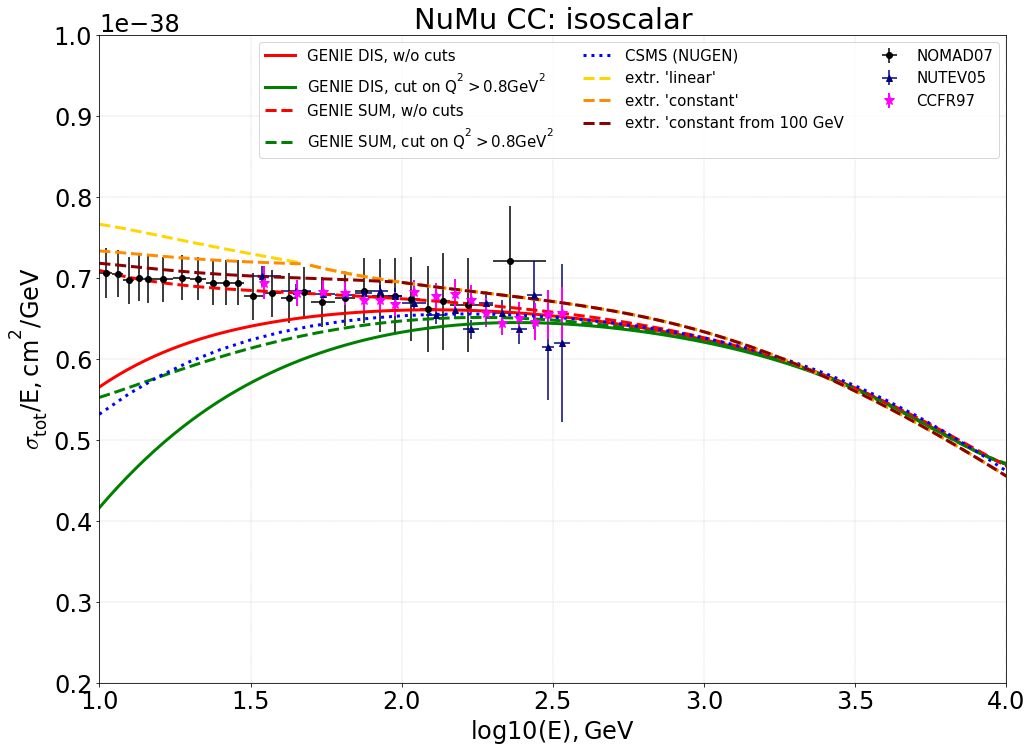

In [50]:
fitpar_dict_p = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_CC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_CC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

pth_extr='/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en'
d = np.load(pth_extr+'/interp/1GeV_interp_NuMu_CC_iso.npy')[0]
f = d['poly_coef']
c = d['c']
l = d['linear']

f = plot_xsec_corr_with_genie_xml(f, c, l,
                                  linfit_max_lgE = 2.,
                                  il_genie_p=ind_NuMu_CC_p, il_genie_n=ind_NuMu_CC_n,
                                  il_genie_xml_p=ind_genie_NuMu_CC_p, 
                                  il_genie_xml_n=ind_genie_NuMu_CC_n,
                                  il_genie_ch_xml_p=ind_genie_ch_NuMu_CC_p, 
                                  il_genie_ch_xml_n=ind_genie_ch_NuMu_CC_n,
                                  k_gxml='nu_cc',
                                  key_csms = 'total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                                  title = 'NuMu CC', save_name = 'NuMu_CC', 
                                  y_r=[0.2e-38,1.e-38])

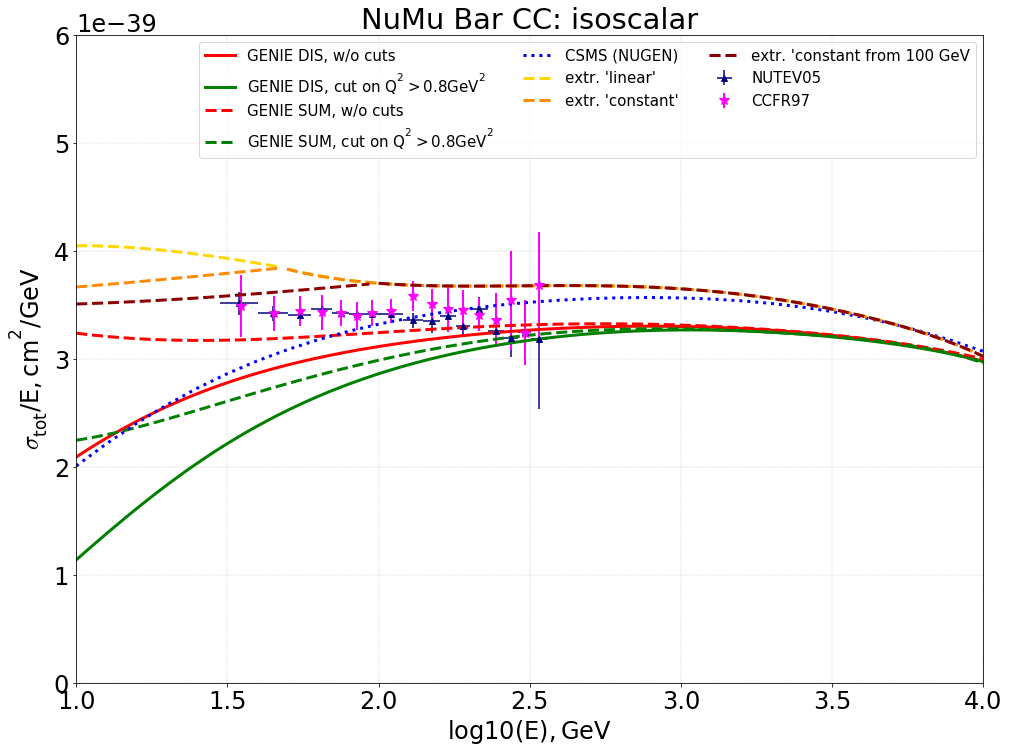

In [51]:
fitpar_dict_p = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_CC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_CC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

pth_extr='/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en'
d = np.load(pth_extr+'/interp/1GeV_interp_NuMu_Bar_CC_iso.npy')[0]
f = d['poly_coef']
c = d['c']
l = d['linear']

f = plot_xsec_corr_with_genie_xml(f, c, l,
                                  linfit_max_lgE = 2.,
                                  il_genie_p=ind_NuMu_Bar_CC_p, 
                                  il_genie_n=ind_NuMu_Bar_CC_n,
                                  il_genie_xml_p=ind_genie_NuMu_Bar_CC_p, 
                                  il_genie_xml_n=ind_genie_NuMu_Bar_CC_n,
                                  il_genie_ch_xml_p=ind_genie_ch_NuMu_Bar_CC_p, 
                                  il_genie_ch_xml_n=ind_genie_ch_NuMu_Bar_CC_n,
                                  k_gxml='nubar_cc',
                                  key_csms = 'total_nubar_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                                  title = 'NuMu Bar CC', y_r=[0.e-38,.6e-38])

In [52]:
def plot_xsec_corr_with_genie_xml(f, freeze, linfit_corr,
                                  linfit_max_lgE = 2.,
                                  il_genie_p=ind_NuMu_CC_p, 
                                  il_genie_n=ind_NuMu_CC_n,
                                  il_genie_xml_p=ind_genie_NuMu_CC_p, 
                                  il_genie_xml_n=ind_genie_NuMu_CC_n,
                                  il_genie_ch_xml_p=ind_genie_ch_NuMu_CC_p, 
                                  il_genie_ch_xml_n=ind_genie_ch_NuMu_CC_n,
                                  k_gxml = 'nu_cc',
                                  key_csms = 'total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                                  title = 'NuMu CC', save_name = 'NuMu_CC',
                                  y_r=[0.,1.e-38]):
    
    fig = plt.figure()
    fig.set_figheight(12)
    fig.set_figwidth(15)
    ax = plt.axes(rect1)

    E_min = 1.

    
    ax.set_xlim(E_min,4.)
    ax.set_ylim(y_r)
    ax.set_title(title + ': isoscalar')
    ax.set_ylabel(r'$\mathrm{\sigma_{tot}/E, cm^2/GeV}$')

    comm_x = np.linspace(E_min,4.0,100)
    
#     ax.plot(xsec_csms[key_csms]['lgE'], 
#             xsec_csms[key_csms]['xsec_per_E'],
#             lw=3, linestyle=':', color='b', label = 'CSMS (NUGEN)')
    
    x = xsec_csms[key_csms]['lgE']
    y = xsec_csms[key_csms]['xsec_per_E']
    fitpar = np.polyfit(x, y, 9)
    fit_dat_csms = np.polyval(fitpar, comm_x)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ew = 2.
    if title == 'NuMu Bar CC':
        plt.errorbar(nutev['lgE'], nutev['sig_nubar']*1e-38, 
                     xerr=nutev['lgE_half_bin'], yerr=(nutev['stat_nubar']+nutev['syst_nubar'])*1e-38,
                     markersize=10, lw=2.5, elinewidth=ew,
                     fmt='^', c='navy', label='NUTEV05')
        plt.errorbar(ccfr['lgE'], ccfr['sig_nubar']*1e-38, 
                     yerr=(ccfr['stat_nubar']+ccfr['syst_nubar'])*1e-38,
                     fmt='*', c='green', lw=2.5, markersize=15, elinewidth=ew,
                     label=r'CCFR97')
        
    if title == 'NuMu CC':
        
        plt.errorbar(nomad['lgE'], nomad['xsecE']*1e-38, 
                     xerr=nomad['lgE_err'], yerr=nomad['xsecE_err']*1e-38,
                     markersize=10, elinewidth=ew,
                     fmt='ko', label='NOMAD07')
        plt.errorbar(nutev['lgE'], nutev['sig_nu']*1e-38, 
                     xerr=nutev['lgE_half_bin'], yerr=(nutev['stat_nu']+nutev['syst_nu'])*1e-38,
                     markersize=10, elinewidth=ew,
                     fmt='^', c='navy', label='NUTEV05')
        plt.errorbar(ccfr['lgE'], ccfr['sig_nu']*1e-38, 
                     yerr=(ccfr['stat_nu']+ccfr['syst_nu'])*1e-38,
                     fmt='*', c='green', lw=2., markersize=15, elinewidth=ew,
                     label=r'CCFR97')
        
  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    fit_arr_p = []
    for i in range(len(il_genie_p)):

        i_g2 = il_genie_p[i]
        if len(i_g2) > 0:
            x = lgE_genie_p[i_g2]
            y = xsec_E_genie_p[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_p.append(fit)
            
    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_n = []
    for i in range(len(il_genie_n)):

        i_g2 = il_genie_n[i]
        if len(i_g2) > 0:
            x = lgE_genie_n[i_g2]
            y = xsec_E_genie_n[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_n.append(fit)

    fit_arr_n = np.array(fit_arr_n)
    sum_fit_n = np.sum(fit_arr_n, axis=0)
    
    sum_fit_iso = (sum_fit_p+sum_fit_n)/2.
    
#     ax.plot(comm_x, sum_fit_iso, linestyle='-', c='red', lw=3, 
#             label=r'GENIE DIS')
    
    fit_xyQ2_p = np.polyval(cut_xyQ2_p, comm_x)
    fit_xyQ2_n = np.polyval(cut_xyQ2_n, comm_x)
    
    sum_fit_iso_cuts = (sum_fit_p*fit_xyQ2_p+sum_fit_n*fit_xyQ2_n)/2.
    
#     ax.plot(comm_x, sum_fit_iso_cuts, '-', c='g', lw=3, 
#             label=r'GENIE DIS, cut on $\mathrm{Q^2>0.8 GeV^2}$')
    
    f = np.polyfit(comm_x, fit_dat_csms/sum_fit_iso_cuts, 8)
    f_v = np.polyval(f, comm_x)
    
#     ax.plot(comm_x, sum_fit_iso*f_v, linestyle='--', c='cyan', lw=3, 
#             label=r'GENIE, w/o cuts, corrected')
    
    ##################################################################################
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    fit_arr_p = []
    for i in range(len(genie_xml_sum_DIS['E'][k_gxml]['p'])):

        x = np.log10(genie_xml_sum_DIS['E'][k_gxml]['p'][i])[150:]
        y = (genie_xml_sum_DIS['xsec'][k_gxml]['p'][i]/genie_xml_sum_DIS['E'][k_gxml]['p'][i]*conv)[150:]
        fitpar = np.polyfit(x, y, 6)
        fit = np.polyval(fitpar, comm_x)
        fit_arr_p.append(fit)
            
    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_n = []
    for i in range(len(genie_xml_sum_DIS['E'][k_gxml]['n'])):

        x = np.log10(genie_xml_sum_DIS['E'][k_gxml]['n'][i])[150:]
        y = (genie_xml_sum_DIS['xsec'][k_gxml]['n'][i]/genie_xml_sum_DIS['E'][k_gxml]['n'][i]*conv)[150:]
        fitpar = np.polyfit(x, y, 6)
        fit = np.polyval(fitpar, comm_x)
        fit_arr_n.append(fit)

    fit_arr_n = np.array(fit_arr_n)
    sum_fit_n = np.sum(fit_arr_n, axis=0)
    
    sum_fit_iso_DIS = (sum_fit_p+sum_fit_n)/2.
    
#     ax.plot(comm_x, sum_fit_iso_DIS, linestyle='-', c='pink', lw=3, label=r'GENIE xsec DIS')

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    fit_arr_p = []
    for i in range(len(genie_xml_sum_notDIS['E'][k_gxml]['p'])):

        x = np.log10(genie_xml_sum_notDIS['E'][k_gxml]['p'][i])[150:]
        y = (genie_xml_sum_notDIS['xsec'][k_gxml]['p'][i]/genie_xml_sum_notDIS['E'][k_gxml]['p'][i]*conv)[150:]
        fitpar = np.polyfit(x, y, 6)
        fit = np.polyval(fitpar, comm_x)
        fit_arr_p.append(fit)
            
    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_n = []
    for i in range(len(genie_xml_sum_notDIS['E'][k_gxml]['n'])):

        x = np.log10(genie_xml_sum_notDIS['E'][k_gxml]['n'][i])[150:]
        y = (genie_xml_sum_notDIS['xsec'][k_gxml]['n'][i]/genie_xml_sum_notDIS['E'][k_gxml]['n'][i]*conv)[150:]
        fitpar = np.polyfit(x, y, 6)
        fit = np.polyval(fitpar, comm_x)
        fit_arr_n.append(fit)

    fit_arr_n = np.array(fit_arr_n)
    sum_fit_n = np.sum(fit_arr_n, axis=0)
    
    sum_fit_iso_notDIS = (sum_fit_p+sum_fit_n)/2.
    
#     ax.plot(comm_x, sum_fit_iso_notDIS, linestyle='-', c='pink', lw=3, label=r'GENIE xsec notDIS')
    
    ax.plot(comm_x, sum_fit_iso_DIS+sum_fit_iso_notDIS, linestyle='--', c='red', lw=3, 
            label=r'GENIE SUM')
#     ax.plot(comm_x, sum_fit_iso_cuts+sum_fit_iso_notDIS, linestyle='--', c='g', lw=3, 
#             label=r'GENIE SUM, cut on $\mathrm{Q^2>0.8 GeV^2}$')
    
#     ax.plot(xsec_csms[key_csms]['lgE'], 
#             xsec_csms[key_csms]['xsec_per_E'],
#             lw=3, linestyle=':', color='b', label = 'CSMS (NUGEN)')
#     ax.plot(comm_x, sum_fit_iso*f_v+sum_fit_iso_notDIS, linestyle='--', c='brown', lw=3, 
#             label=r'GENIE xsec SUM cuts')

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##################################################################################
    
    ratio_w_cuts = fit_dat_csms/sum_fit_iso_cuts
    comm_x_20 = np.linspace(Emin,4.0,1000)
    f_v = np.polyval(f, comm_x_20)
    #~~~~~~~~~~~~~~~
    ind_50 = np.transpose(np.argwhere(comm_x<1.68))[0]
    ind_fit50 = np.transpose(np.argwhere(comm_x>=1.68))[0]
    ind_100 = np.transpose(np.argwhere(comm_x<2.))[0]
    ind_fit100 = np.transpose(np.argwhere(comm_x>=2.))[0]

    comm_x_50 = comm_x[ind_50]
    comm_x_100 = comm_x[ind_100]
    comm_x_fit50 = comm_x[ind_fit50]
    comm_x_fit100 = comm_x[ind_fit100]
    
    linfit_val_corr = np.polyval(linfit_corr, comm_x_50)

    fit_genie0 = np.polyfit(comm_x, sum_fit_iso, 7)
    sum_fit_iso_less50 = np.polyval(fit_genie0, comm_x_50)
    sum_fit_iso_more50 = np.polyval(fit_genie0, comm_x_fit50)
    sum_fit_iso_less100 = np.polyval(fit_genie0, comm_x_100)
    sum_fit_iso_more100 = np.polyval(fit_genie0, comm_x_fit100)
    
    ax.plot(comm_x_50, 
            sum_fit_iso_less50*linfit_val_corr+sum_fit_iso_notDIS[ind_50], 
            c='gold', 
            lw=3., linestyle='--', 
            label=r"extr. 'linear'")
    ax.plot(comm_x_fit50, 
            sum_fit_iso_more50*np.polyval(f, comm_x_fit50)+sum_fit_iso_notDIS[ind_fit50], 
            c='gold', lw=3., linestyle='--', 
            )
    
    ax.plot(comm_x_50, 
            sum_fit_iso_less50*np.polyval(f, 1.68)+sum_fit_iso_notDIS[ind_50], 
            c='darkorange', lw=3., linestyle='--', 
            label=r"extr. 'constant'")
    ax.plot(comm_x_fit50, 
            sum_fit_iso_more50*np.polyval(f, comm_x_fit50)+sum_fit_iso_notDIS[ind_fit50], 
            c='darkorange', lw=3., linestyle='--', 
            )
    
    ax.plot(comm_x_100, 
            sum_fit_iso_less100*np.polyval(f, 2.)+sum_fit_iso_notDIS[ind_100], 
            c='darkred', lw=3., linestyle='--', 
            label=r"extr. 'constant from 100 GeV")
    ax.plot(comm_x_fit100, 
            sum_fit_iso_more100*np.polyval(f, comm_x_fit100)+sum_fit_iso_notDIS[ind_fit100], 
            c='darkred', lw=3., linestyle='--', 
            )
    ##################################################################################
    ##################################################################################
    ax.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)
    plt.legend(fontsize=15, ncol=3)
    ax.set_xlabel(r'$\mathrm{log10(E), GeV}$')

    save_name = title.replace(' ', '_')
#     save_pth = ''
    plt.xlim(1., 3.)
    plt.savefig(save_pth+save_name+'_with_data_1GeV'+'.png', dpi='figure')
    plt.savefig(save_pth+save_name+'_with_data_1GeV'+'.pdf', dpi='figure')
#     plt.show()
    
    return f

/home/maria/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/maria/.local/lib/python2.7/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


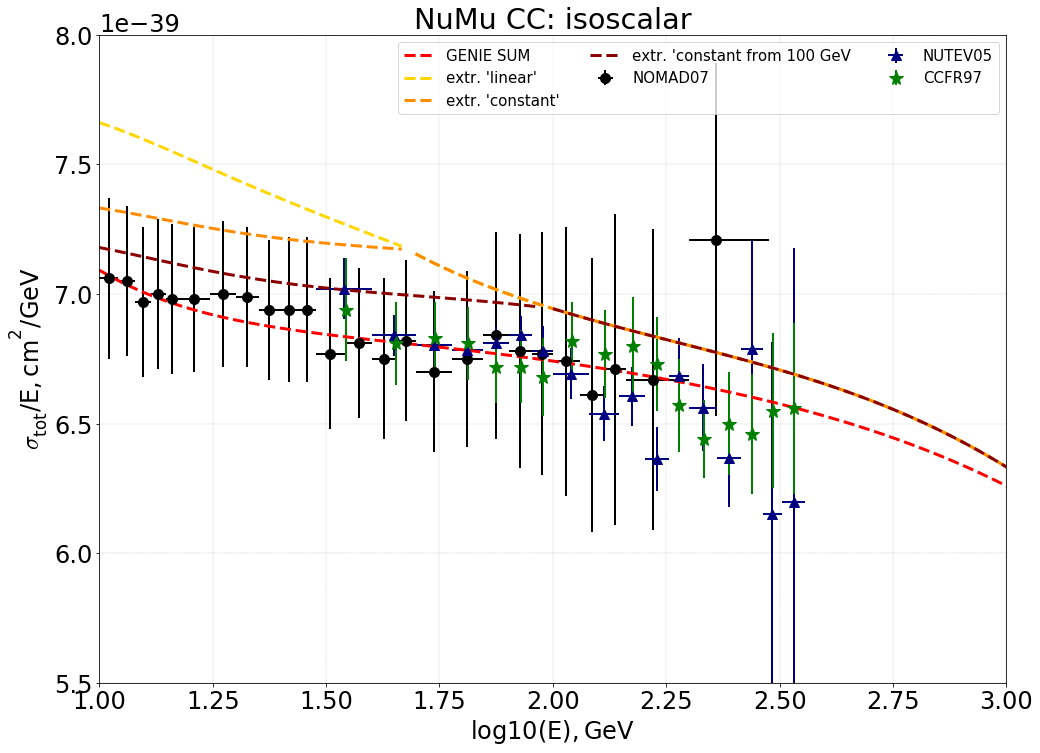

In [53]:
fitpar_dict_p = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_CC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_CC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

pth_extr='/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en'
d = np.load(pth_extr+'/interp/1GeV_interp_NuMu_CC_iso.npy')[0]
f = d['poly_coef']
c = d['c']
l = d['linear']

f = plot_xsec_corr_with_genie_xml(f, c, l,
                                  linfit_max_lgE = 2.,
                                  il_genie_p=ind_NuMu_CC_p, il_genie_n=ind_NuMu_CC_n,
                                  il_genie_xml_p=ind_genie_NuMu_CC_p, 
                                  il_genie_xml_n=ind_genie_NuMu_CC_n,
                                  il_genie_ch_xml_p=ind_genie_ch_NuMu_CC_p, 
                                  il_genie_ch_xml_n=ind_genie_ch_NuMu_CC_n,
                                  k_gxml='nu_cc',
                                  key_csms = 'total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                                  title = 'NuMu CC', save_name = 'NuMu_CC', 
                                  y_r=[0.55e-38,.8e-38])



(1.0, 3.0)

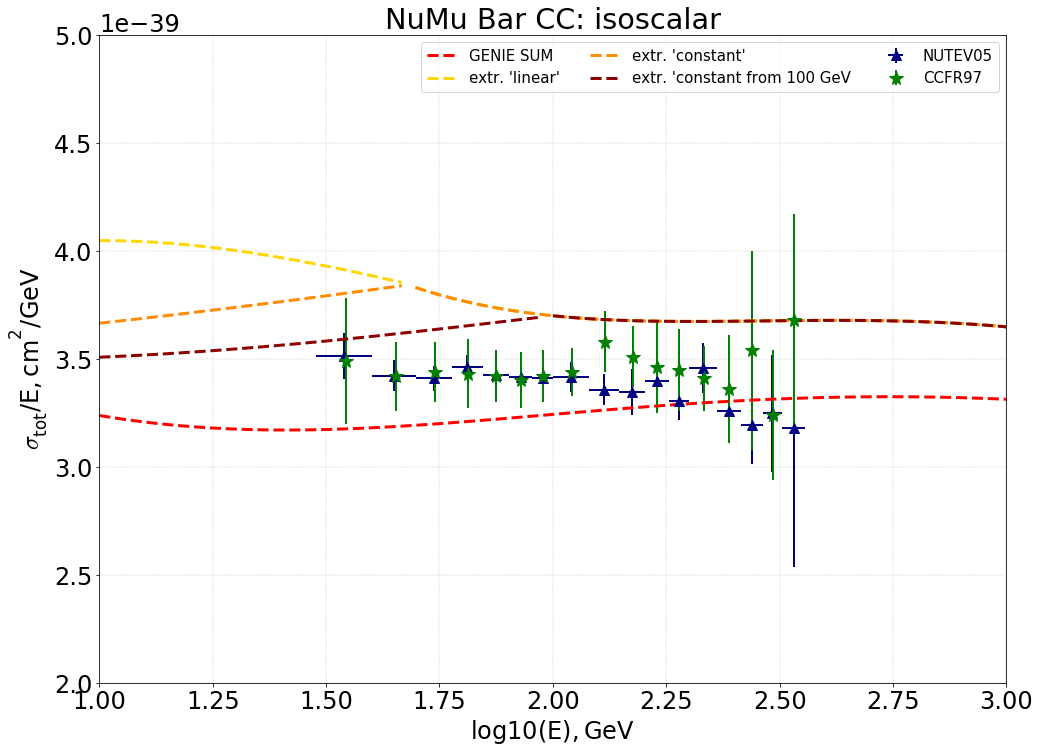

In [54]:
fitpar_dict_p = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_CC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_CC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

pth_extr='/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en'
d = np.load(pth_extr+'/interp/1GeV_interp_NuMu_Bar_CC_iso.npy')[0]
f = d['poly_coef']
c = d['c']
l = d['linear']

f = plot_xsec_corr_with_genie_xml(f, c, l,
                                  linfit_max_lgE = 2.,
                                  il_genie_p=ind_NuMu_Bar_CC_p, 
                                  il_genie_n=ind_NuMu_Bar_CC_n,
                                  il_genie_xml_p=ind_genie_NuMu_Bar_CC_p, 
                                  il_genie_xml_n=ind_genie_NuMu_Bar_CC_n,
                                  il_genie_ch_xml_p=ind_genie_ch_NuMu_Bar_CC_p, 
                                  il_genie_ch_xml_n=ind_genie_ch_NuMu_Bar_CC_n,
                                  k_gxml='nubar_cc',
                                  key_csms = 'total_nubar_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                                  title = 'NuMu Bar CC', y_r=[0.2e-38,.5e-38])

plt.xlim(1., 3.)

In [55]:
def plot_xsec_corr_with_genie_xml(f, freeze, linfit_corr,
                                  linfit_max_lgE = 2.,
                                  il_genie_p=ind_NuMu_CC_p, 
                                  il_genie_n=ind_NuMu_CC_n,
                                  il_genie_xml_p=ind_genie_NuMu_CC_p, 
                                  il_genie_xml_n=ind_genie_NuMu_CC_n,
                                  il_genie_ch_xml_p=ind_genie_ch_NuMu_CC_p, 
                                  il_genie_ch_xml_n=ind_genie_ch_NuMu_CC_n,
                                  k_gxml = 'nu_cc',
                                  key_csms = 'total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                                  title = 'NuMu CC', save_name = 'NuMu_CC',
                                  y_r=[0.,1.e-38]):
    
    fig = plt.figure()
    fig.set_figheight(12)
    fig.set_figwidth(15)
    ax = plt.axes(rect1)

    E_min = 1.
    
    ax.set_xlim(E_min,4.)
    ax.set_ylim(y_r)
    ax.set_title(title + ': isoscalar')
    ax.set_ylabel(r'$\mathrm{\sigma_{tot}/E, cm^2/GeV}$')

    comm_x = np.linspace(E_min,4.0,100)
    
#     ax.plot(xsec_csms[key_csms]['lgE'], 
#             xsec_csms[key_csms]['xsec_per_E'],
#             lw=3, linestyle=':', color='b', label = 'CSMS (NUGEN)')
    
    x = xsec_csms[key_csms]['lgE']
    y = xsec_csms[key_csms]['xsec_per_E']
    fitpar = np.polyfit(x, y, 9)
    fit_dat_csms = np.polyval(fitpar, comm_x)
    
  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    fit_arr_p = []
    for i in range(len(il_genie_p)):

        i_g2 = il_genie_p[i]
        if len(i_g2) > 0:
            x = lgE_genie_p[i_g2]
            y = xsec_E_genie_p[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_p.append(fit)
            
    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_n = []
    for i in range(len(il_genie_n)):

        i_g2 = il_genie_n[i]
        if len(i_g2) > 0:
            x = lgE_genie_n[i_g2]
            y = xsec_E_genie_n[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_n.append(fit)

    fit_arr_n = np.array(fit_arr_n)
    sum_fit_n = np.sum(fit_arr_n, axis=0)
    
    sum_fit_iso = (sum_fit_p+sum_fit_n)/2.
    
    ax.plot(comm_x, sum_fit_iso, linestyle='-', c='red', lw=3, 
            label=r'GENIE DIS')
    
    fit_xyQ2_p = np.polyval(cut_xyQ2_p, comm_x)
    fit_xyQ2_n = np.polyval(cut_xyQ2_n, comm_x)
    
    sum_fit_iso_cuts = (sum_fit_p*fit_xyQ2_p+sum_fit_n*fit_xyQ2_n)/2.
    
    ax.plot(comm_x, sum_fit_iso_cuts, '-', c='g', lw=3, 
            label=r'GENIE DIS, cut on $\mathrm{Q^2>0.8 GeV^2}$')
    
    f = np.polyfit(comm_x, fit_dat_csms/sum_fit_iso_cuts, 8)
    f_v = np.polyval(f, comm_x)
    
#     ax.plot(comm_x, sum_fit_iso*f_v, linestyle='--', c='cyan', lw=3, 
#             label=r'GENIE, w/o cuts, corrected')
    
    ##################################################################################
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    fit_arr_p = []
    for i in range(len(genie_xml_sum_DIS['E'][k_gxml]['p'])):

        x = np.log10(genie_xml_sum_DIS['E'][k_gxml]['p'][i])[150:]
        y = (genie_xml_sum_DIS['xsec'][k_gxml]['p'][i]/genie_xml_sum_DIS['E'][k_gxml]['p'][i]*conv)[150:]
        fitpar = np.polyfit(x, y, 6)
        fit = np.polyval(fitpar, comm_x)
        fit_arr_p.append(fit)
            
    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_n = []
    for i in range(len(genie_xml_sum_DIS['E'][k_gxml]['n'])):

        x = np.log10(genie_xml_sum_DIS['E'][k_gxml]['n'][i])[150:]
        y = (genie_xml_sum_DIS['xsec'][k_gxml]['n'][i]/genie_xml_sum_DIS['E'][k_gxml]['n'][i]*conv)[150:]
        fitpar = np.polyfit(x, y, 6)
        fit = np.polyval(fitpar, comm_x)
        fit_arr_n.append(fit)

    fit_arr_n = np.array(fit_arr_n)
    sum_fit_n = np.sum(fit_arr_n, axis=0)
    
    sum_fit_iso_DIS = (sum_fit_p+sum_fit_n)/2.
    
#     ax.plot(comm_x, sum_fit_iso_DIS, linestyle='-', c='pink', lw=3, label=r'GENIE xsec DIS')

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    fit_arr_p = []
    for i in range(len(genie_xml_sum_notDIS['E'][k_gxml]['p'])):

        x = np.log10(genie_xml_sum_notDIS['E'][k_gxml]['p'][i])[150:]
        y = (genie_xml_sum_notDIS['xsec'][k_gxml]['p'][i]/genie_xml_sum_notDIS['E'][k_gxml]['p'][i]*conv)[150:]
        fitpar = np.polyfit(x, y, 6)
        fit = np.polyval(fitpar, comm_x)
        fit_arr_p.append(fit)
            
    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_n = []
    for i in range(len(genie_xml_sum_notDIS['E'][k_gxml]['n'])):

        x = np.log10(genie_xml_sum_notDIS['E'][k_gxml]['n'][i])[150:]
        y = (genie_xml_sum_notDIS['xsec'][k_gxml]['n'][i]/genie_xml_sum_notDIS['E'][k_gxml]['n'][i]*conv)[150:]
        fitpar = np.polyfit(x, y, 6)
        fit = np.polyval(fitpar, comm_x)
        fit_arr_n.append(fit)

    fit_arr_n = np.array(fit_arr_n)
    sum_fit_n = np.sum(fit_arr_n, axis=0)
    
    sum_fit_iso_notDIS = (sum_fit_p+sum_fit_n)/2.
    
#     ax.plot(comm_x, sum_fit_iso_notDIS, linestyle='-', c='pink', lw=3, label=r'GENIE xsec notDIS')
    
    ax.plot(comm_x, sum_fit_iso_DIS+sum_fit_iso_notDIS, linestyle='--', c='red', lw=3, 
            label=r'GENIE SUM')
#     ax.plot(comm_x, sum_fit_iso_cuts+sum_fit_iso_notDIS, linestyle='--', c='g', lw=3, 
#             label=r'GENIE SUM, cut on $\mathrm{Q^2>0.8 GeV^2}$')
    
    ax.plot(xsec_csms[key_csms]['lgE'], 
            xsec_csms[key_csms]['xsec_per_E'],
            lw=3, linestyle=':', color='b', label = 'CSMS (NUGEN)')
#     ax.plot(comm_x, sum_fit_iso*f_v+sum_fit_iso_notDIS, linestyle='--', c='brown', lw=3, 
#             label=r'GENIE xsec SUM cuts')

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##################################################################################
    
    ratio_w_cuts = fit_dat_csms/sum_fit_iso_cuts
    comm_x_20 = np.linspace(Emin,4.0,1000)
    f_v = np.polyval(f, comm_x_20)
    #~~~~~~~~~~~~~~~
    ind_50 = np.transpose(np.argwhere(comm_x<1.68))[0]
    ind_fit50 = np.transpose(np.argwhere(comm_x>=1.68))[0]
    ind_100 = np.transpose(np.argwhere(comm_x<2.))[0]
    ind_fit100 = np.transpose(np.argwhere(comm_x>=2.))[0]

    comm_x_50 = comm_x[ind_50]
    comm_x_100 = comm_x[ind_100]
    comm_x_fit50 = comm_x[ind_fit50]
    comm_x_fit100 = comm_x[ind_fit100]
    
    linfit_val_corr = np.polyval(linfit_corr, comm_x_50)

    fit_genie0 = np.polyfit(comm_x, sum_fit_iso, 7)
    sum_fit_iso_less50 = np.polyval(fit_genie0, comm_x_50)
    sum_fit_iso_more50 = np.polyval(fit_genie0, comm_x_fit50)
    sum_fit_iso_less100 = np.polyval(fit_genie0, comm_x_100)
    sum_fit_iso_more100 = np.polyval(fit_genie0, comm_x_fit100)
    
#     ax.plot(comm_x_50, 
#             sum_fit_iso_less50*linfit_val_corr+sum_fit_iso_notDIS[ind_50], 
#             c='gold', 
#             lw=3., linestyle='--', 
#             label=r"extr. 'linear'")
#     ax.plot(comm_x_fit50, 
#             sum_fit_iso_more50*np.polyval(f, comm_x_fit50)+sum_fit_iso_notDIS[ind_fit50], 
#             c='gold', lw=3., linestyle='--', 
#             )
    
#     ax.plot(comm_x_50, 
#             sum_fit_iso_less50*np.polyval(f, 1.68)+sum_fit_iso_notDIS[ind_50], 
#             c='darkorange', lw=3., linestyle='--', 
#             label=r"extr. 'constant'")
#     ax.plot(comm_x_fit50, 
#             sum_fit_iso_more50*np.polyval(f, comm_x_fit50)+sum_fit_iso_notDIS[ind_fit50], 
#             c='darkorange', lw=3., linestyle='--', 
#             )
    
#     ax.plot(comm_x_100, 
#             sum_fit_iso_less100*np.polyval(f, 2.)+sum_fit_iso_notDIS[ind_100], 
#             c='darkred', lw=3., linestyle='--', 
#             label=r"extr. 'constant from 100 GeV")
#     ax.plot(comm_x_fit100, 
#             sum_fit_iso_more100*np.polyval(f, comm_x_fit100)+sum_fit_iso_notDIS[ind_fit100], 
#             c='darkred', lw=3., linestyle='--', 
#             )
    ##################################################################################
    ##################################################################################
    ax.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)
    plt.legend(fontsize=15, ncol=2)
    ax.set_xlabel(r'$\mathrm{log10(E), GeV}$')

    save_name = title.replace(' ', '_')
#     save_pth = ''
    plt.savefig(save_pth+save_name+'_before_correction_1GeV'+'.png', dpi='figure')
    plt.savefig(save_pth+save_name+'_before_correction_1GeV'+'.pdf', dpi='figure')
    plt.show()
    
    return f

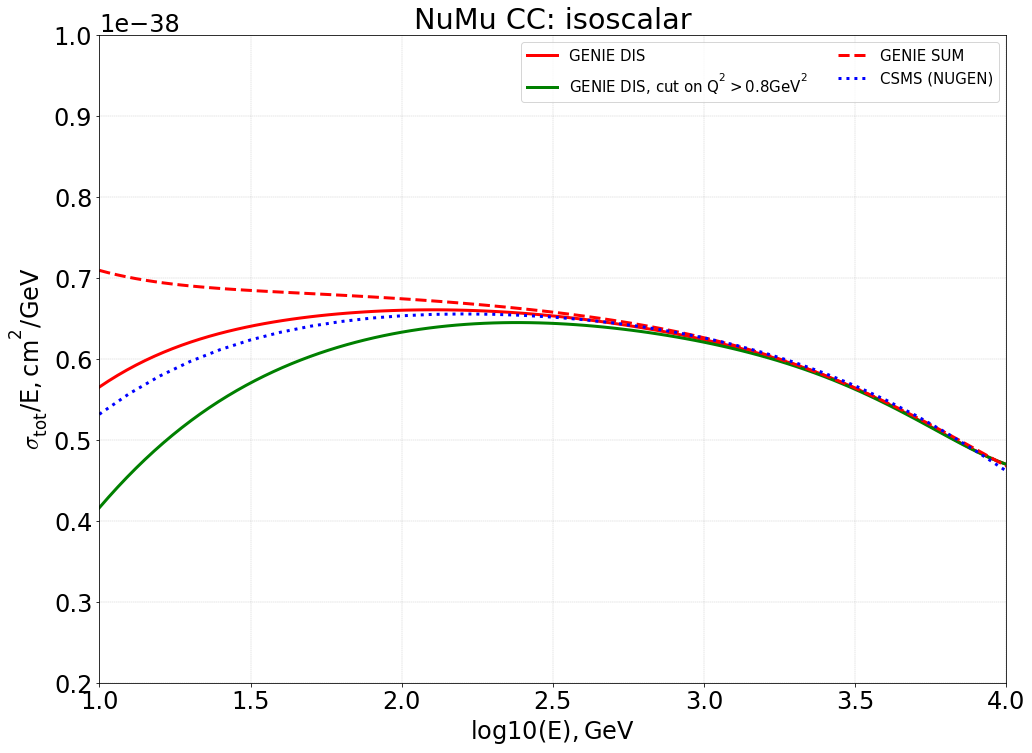

In [56]:
fitpar_dict_p = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_CC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_CC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

pth_extr='/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en'
d = np.load(pth_extr+'/interp/1GeV_interp_NuMu_CC_iso.npy')[0]
f = d['poly_coef']
c = d['c']
l = d['linear']

f = plot_xsec_corr_with_genie_xml(f, c, l,
                                  linfit_max_lgE = 2.,
                                  il_genie_p=ind_NuMu_CC_p, il_genie_n=ind_NuMu_CC_n,
                                  il_genie_xml_p=ind_genie_NuMu_CC_p, 
                                  il_genie_xml_n=ind_genie_NuMu_CC_n,
                                  il_genie_ch_xml_p=ind_genie_ch_NuMu_CC_p, 
                                  il_genie_ch_xml_n=ind_genie_ch_NuMu_CC_n,
                                  k_gxml='nu_cc',
                                  key_csms = 'total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                                  title = 'NuMu CC', save_name = 'NuMu_CC', 
                                  y_r=[0.2e-38,1.e-38])

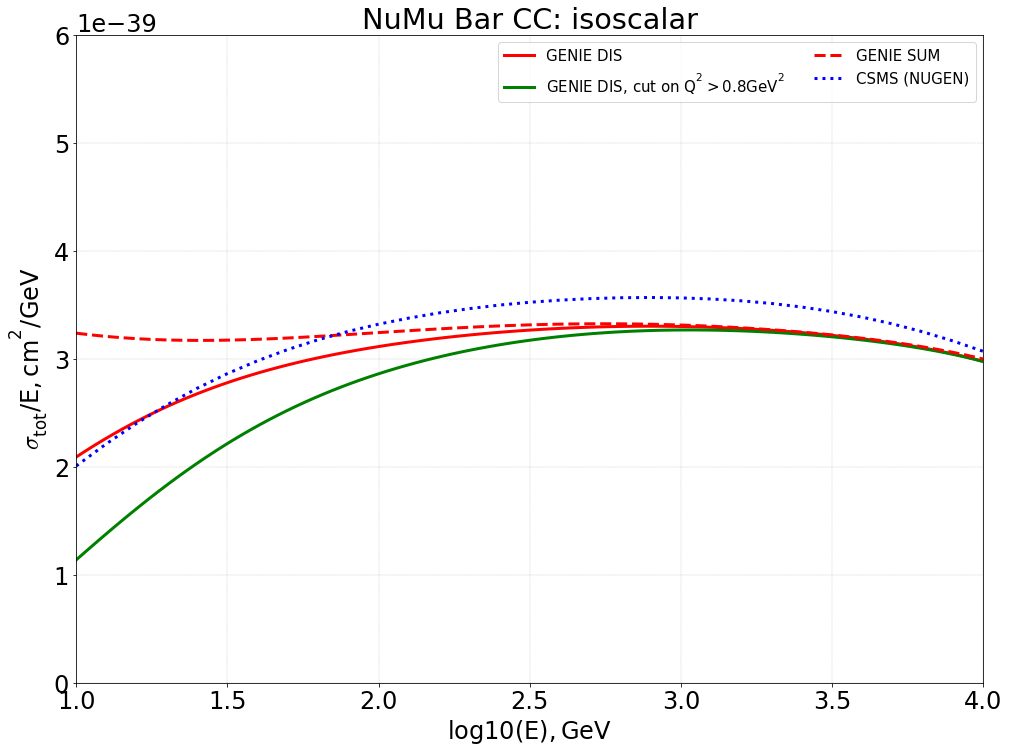

In [57]:
fitpar_dict_p = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_CC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_CC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

pth_extr='/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en'
d = np.load(pth_extr+'/interp/1GeV_interp_NuMu_Bar_CC_iso.npy')[0]
f = d['poly_coef']
c = d['c']
l = d['linear']

f = plot_xsec_corr_with_genie_xml(f, c, l,
                                  linfit_max_lgE = 2.,
                                  il_genie_p=ind_NuMu_Bar_CC_p, 
                                  il_genie_n=ind_NuMu_Bar_CC_n,
                                  il_genie_xml_p=ind_genie_NuMu_Bar_CC_p, 
                                  il_genie_xml_n=ind_genie_NuMu_Bar_CC_n,
                                  il_genie_ch_xml_p=ind_genie_ch_NuMu_Bar_CC_p, 
                                  il_genie_ch_xml_n=ind_genie_ch_NuMu_Bar_CC_n,
                                  k_gxml='nubar_cc',
                                  key_csms = 'total_nubar_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                                  title = 'NuMu Bar CC', y_r=[0.e-38,.6e-38])